In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split



In [2]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import tqdm

class CatNotCatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the animal subdirectories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Load all image file paths and their labels ('cat' or 'not cat')
        for sub_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, sub_dir)
            if os.path.isdir(class_path):
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
                        img_path = os.path.join(class_path, img_file)
                        # Label 1 for cat, 0 for not cat
                        label = 1 if sub_dir.lower() == 'cat' else 0
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

dataset = CatNotCatDataset(root_dir='one_vs_rest', transform=transform)

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CatOrNotCNN(nn.Module):
    def __init__(self):
        super(CatOrNotCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=64 * 56 * 56, out_features=512)
        self.fc2 = nn.Linear(512, 2)  # 2 classes: cat or not

    def forward(self, x):
        # Store conv layer outputs in a list
        outputs = []

        x1 = self.pool(F.relu(self.conv1(x)))
        outputs.append(x1)
        x2 = self.pool(F.relu(self.conv2(x1)))
        outputs.append(x2)

        x = torch.flatten(x2, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x, outputs  # Return the final output and the conv layer outputs


In [5]:
import matplotlib.pyplot as plt

def visualize_feature_maps(feature_maps):
    # Assuming feature_maps is a list of tensors from the convolutional layers
    for layer, f_map in enumerate(feature_maps):
        layer += 1  # Start layer indexing at 1
        plt.figure(figsize=(20, 15))
        channels = f_map.shape[1]
        
        for i in range(channels):
            plt.subplot(channels // 8 + 1, 8, i + 1)  # Arrange plots in a grid
            plt.imshow(f_map[0, i].detach().cpu().numpy(), cmap='gray')
            plt.axis('off')
        
        plt.show()


In [6]:
def train_model(model, train_loader, val_loader, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm.tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, conv_outputs = model(images)  # Modified to receive conv_outputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Example of how to print the shape of each conv layer output
            #for i, conv_output in enumerate(conv_outputs):
               # print(f"Shape of output from Conv Layer {i+1}: {conv_output.shape}")
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, conv_outputs = model(images)  # Modified to receive conv_outputs
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total}%')

    print('Finished Training')
    
model = CatOrNotCNN()
train_model(model, train_loader, val_loader, num_epochs=10)

 10%|█         | 1/10 [01:05<09:45, 65.07s/it]

Epoch 1, Loss: 0.3719360560354447, Validation Loss: 0.07300028563751017, Accuracy: 98.79629629629629%


 20%|██        | 2/10 [02:17<09:13, 69.23s/it]

Epoch 2, Loss: 0.06391877886619315, Validation Loss: 0.06460413429886103, Accuracy: 98.79629629629629%


 30%|███       | 3/10 [03:32<08:25, 72.18s/it]

Epoch 3, Loss: 0.059177145228251765, Validation Loss: 0.06636830769917544, Accuracy: 98.79629629629629%


 40%|████      | 4/10 [04:51<07:29, 74.89s/it]

Epoch 4, Loss: 0.031065398725409237, Validation Loss: 0.056363641435061305, Accuracy: 98.98148148148148%


 50%|█████     | 5/10 [06:12<06:25, 77.00s/it]

Epoch 5, Loss: 0.027413120528937407, Validation Loss: 0.19148944639000143, Accuracy: 98.79629629629629%


 60%|██████    | 6/10 [07:39<05:21, 80.32s/it]

Epoch 6, Loss: 0.008191427459359635, Validation Loss: 0.09463446949752431, Accuracy: 99.16666666666667%


 70%|███████   | 7/10 [09:05<04:06, 82.15s/it]

Epoch 7, Loss: 0.0030671090557445025, Validation Loss: 0.09568582868087105, Accuracy: 98.79629629629629%


 80%|████████  | 8/10 [10:32<02:47, 83.82s/it]

Epoch 8, Loss: 0.004638470619424963, Validation Loss: 0.15287835401875327, Accuracy: 99.07407407407408%


 90%|█████████ | 9/10 [12:11<01:28, 88.37s/it]

Epoch 9, Loss: 0.007562688280598582, Validation Loss: 0.17776036413355917, Accuracy: 98.88888888888889%


100%|██████████| 10/10 [13:46<00:00, 82.70s/it]

Epoch 10, Loss: 0.003949857220976767, Validation Loss: 0.1794387018437379, Accuracy: 98.70370370370371%
Finished Training


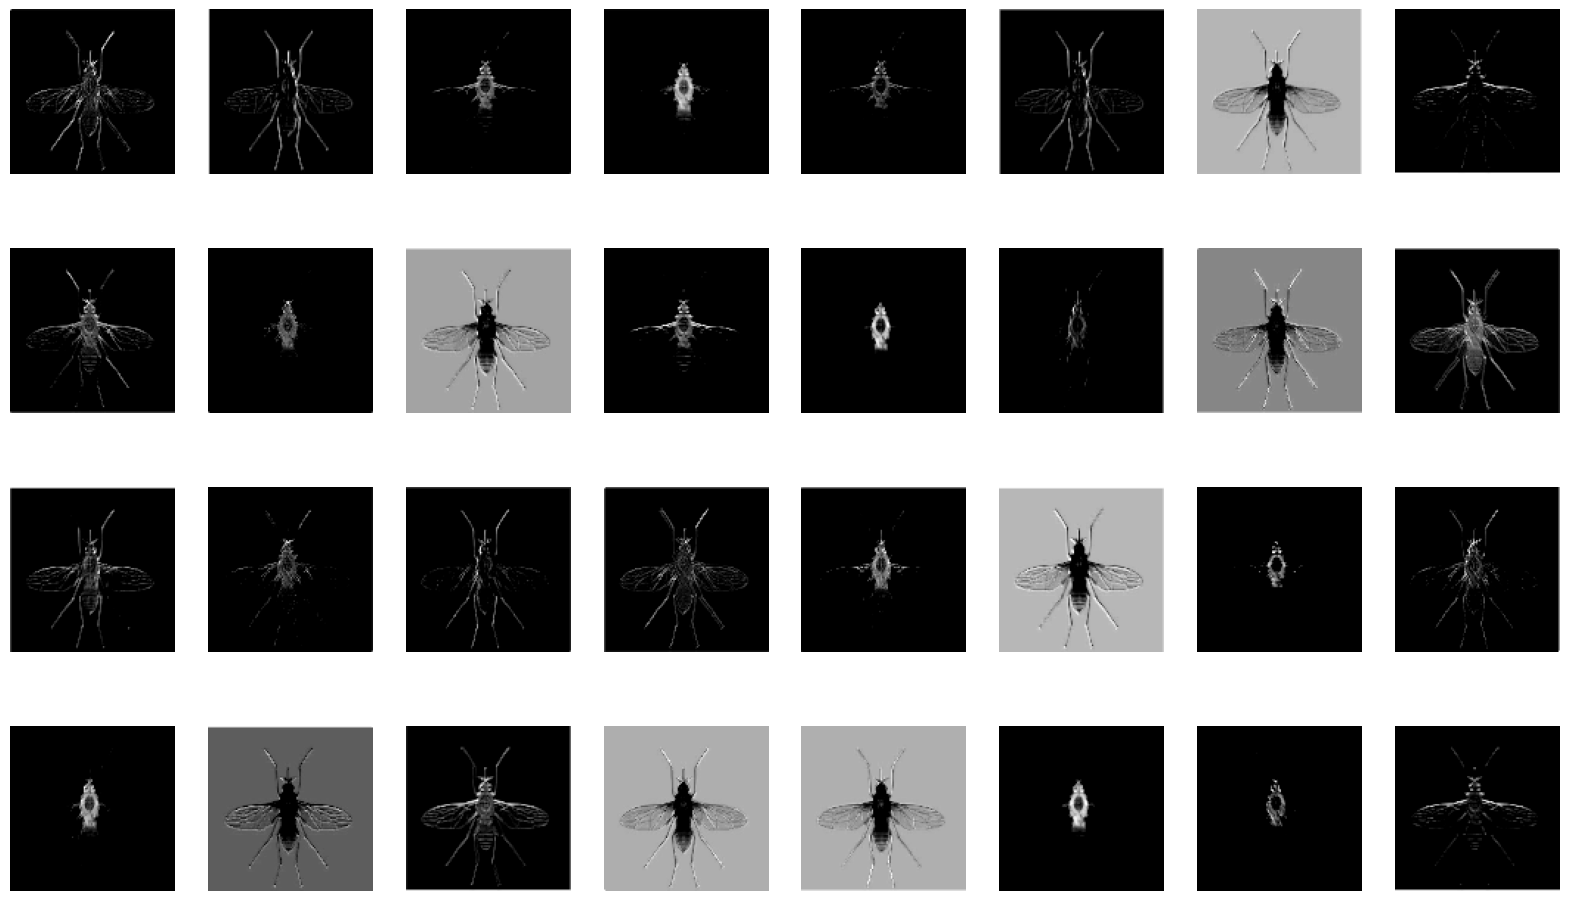

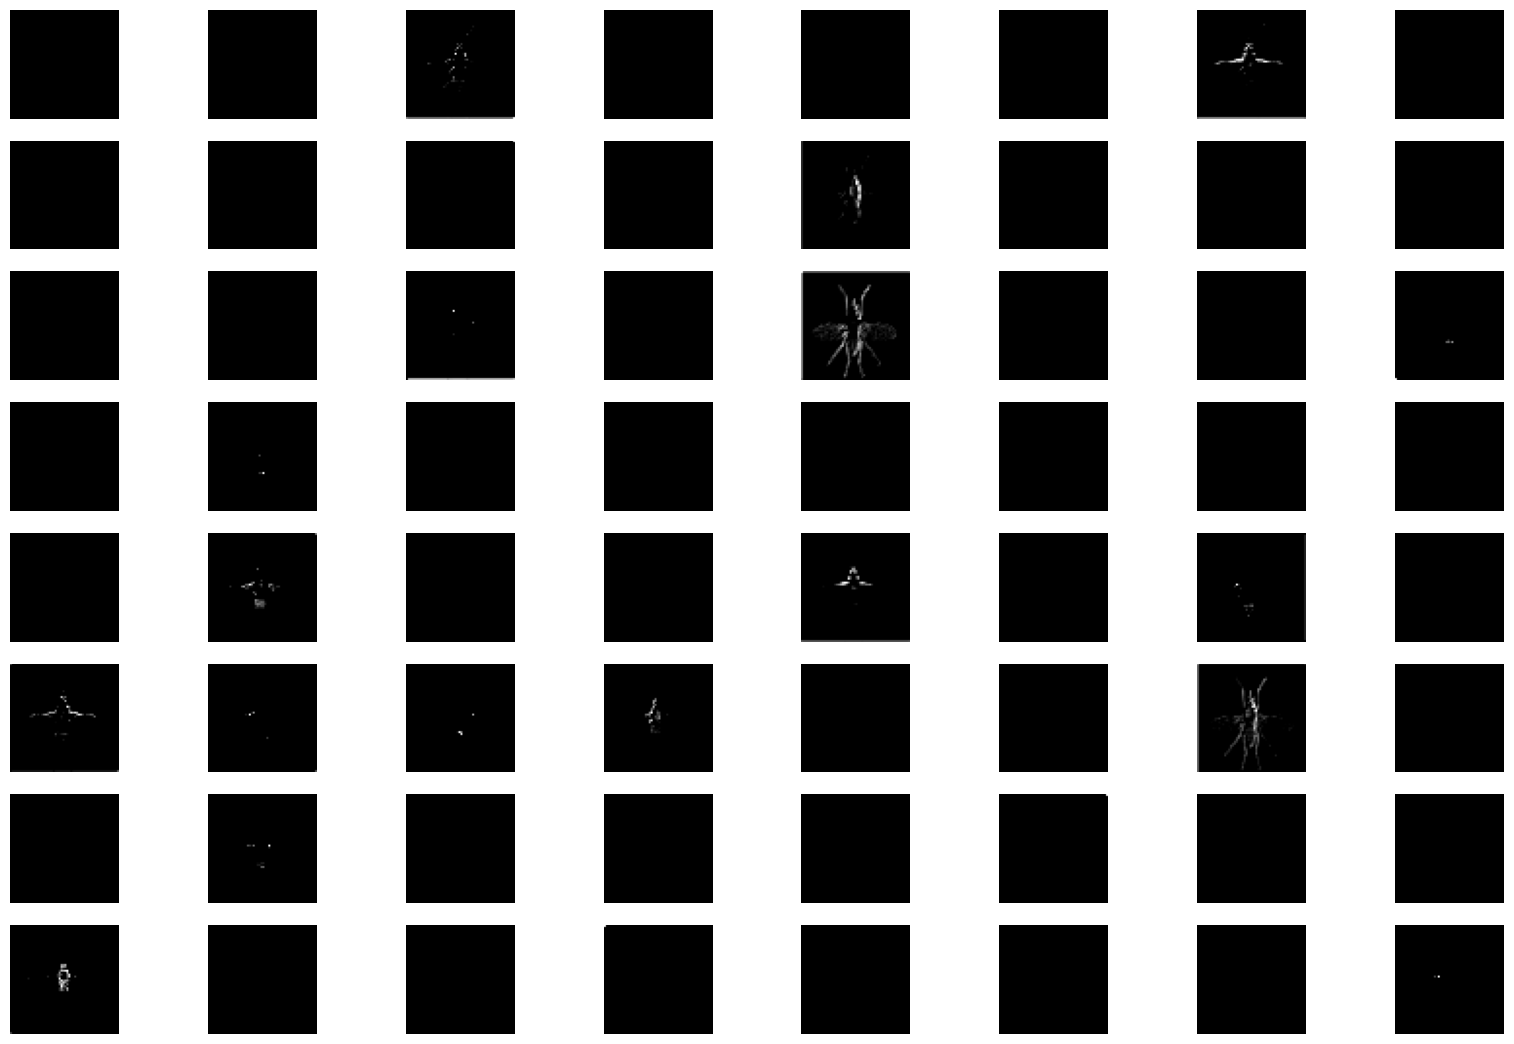

In [7]:
# Assume 'model' is your trained CatOrNotCNN model
# and 'val_loader' is your DataLoader for the validation set

# Turn model to evaluation mode
model.eval()

# Get a single batch of images
images, labels = next(iter(val_loader))

# Move images to the same device as model
images = images.to(next(model.parameters()).device)

# Forward pass to get outputs and feature maps
with torch.no_grad():
    _, feature_maps = model(images)

# Visualize feature maps for the first image in the batch
visualize_feature_maps(feature_maps)
